In [1]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
from warnings import simplefilter 
# import Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils
import re
from Constants import Const

import pydot
from IPython.display import SVG
from graphviz import Digraph

simplefilter(action='ignore')
pd.set_option('display.max_rows', 1000)

In [2]:
import pycausal
from pycausal import search, prior
df = pd.read_csv(Const.data_dir + 'cluster_stuff.csv')
good_cols = []
symptoms = ['pain','voice','teeth','choke','drymouth','mood','skin','mucus','activity']
for c in df.columns:
    if 'symptom' in c and not np.any([s in c for s in symptoms + ['cluster']]):
        continue
    if len(c) > 50:
        continue
#     if 'change' in c:
#         continue
    good_cols.append(c)
df = df[good_cols]
binary_df = pd.concat([pd.get_dummies(df[c],prefix=c) for c in df.columns],axis=1)
binary_df = binary_df[[c for c in binary_df.columns if '_0' not in c]]
binary_df.T

,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
symptom_clusters_1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
symptom_clusters_2,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
symptom_clusters_3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
symptom_clusters_4,0,0,0,1,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
swallow_dose_clusters_1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
swallow_dose_clusters_2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
swallow_dose_clusters_3,1,1,0,1,1,1,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0
cns_dose_clusters_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cns_dose_clusters_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cns_dose_clusters_3,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,0,1,0,0,0,0


In [3]:
def get_constraints(columns,forbid=None,require=None):
    if forbid is None:
        forbid = []
    if require is None:
        require= []
    truncate = lambda x: re.sub('\_\d','',x)
    for c in columns:
        for c2 in columns:
#             if 'baseline' in c:
#                 forbid.append([c2,c])
            if 'baseline' in c and 'dose' in c2:
                forbid.append([c2,c])
            if truncate(c) == truncate(c2):
                forbid.append([c,c2])
            if 'post' in c:# and 'post' not in c2:
                forbid.append([c,c2])
            if 'dose' in c2 and 'dose' not in c:
                forbid.append([c,c2])
    return forbid, require
get_constraints(binary_df.columns)

([['symptom_clusters_1', 'symptom_clusters_1'],
  ['symptom_clusters_1', 'symptom_clusters_2'],
  ['symptom_clusters_1', 'symptom_clusters_3'],
  ['symptom_clusters_1', 'symptom_clusters_4'],
  ['symptom_clusters_1', 'swallow_dose_clusters_1'],
  ['symptom_clusters_1', 'swallow_dose_clusters_2'],
  ['symptom_clusters_1', 'swallow_dose_clusters_3'],
  ['symptom_clusters_1', 'cns_dose_clusters_1'],
  ['symptom_clusters_1', 'cns_dose_clusters_2'],
  ['symptom_clusters_1', 'cns_dose_clusters_3'],
  ['symptom_clusters_1', 'mouth_dose_clusters_1'],
  ['symptom_clusters_1', 'mouth_dose_clusters_2'],
  ['symptom_clusters_1', 'mouth_dose_clusters_3'],
  ['symptom_clusters_1', 'throat_dose_clusters_1'],
  ['symptom_clusters_1', 'throat_dose_clusters_2'],
  ['symptom_clusters_1', 'throat_dose_clusters_3'],
  ['symptom_clusters_1', 'baseline_dose_clusters_1'],
  ['symptom_clusters_1', 'baseline_dose_clusters_2'],
  ['symptom_clusters_1', 'baseline_dose_clusters_3'],
  ['symptom_clusters_1', 'basel

In [4]:
pc = pycausal.pycausal.pycausal()
pc.start_vm()
tetrad = search.tetradrunner()

In [5]:
forbid,require = get_constraints(binary_df.columns)
prior = prior.knowledge(forbiddirect=forbid,requiredirect=require)

In [6]:
tetrad.listScores()

bdeu-score
cci-score
cg-bic-score
cg-other-bic-score
d-sep-score
degen-gauss-bic
disc-bic-score
disc-mixed-bic-score
mnlr-bic-score
mvp-bic-score
sem-bic


In [15]:
tetrad.run(
#         algoId='fges',
    algoId='imgs_cont',
#     algoId='fci',
    dfs=binary_df.astype(int),
    verbose=False,
    alpha=.0001,
    priorKnowledge=prior,
   testId = 'fisher-z-test',
#    scoreId='disc-bic-score',
#    dataType='discrete',
          )
[c for c in tetrad.getEdges() if 'dose' in c and 'symptom' in c]

['baseline_dose_clusters_4 --> symptoms_voice_max_treatment_2',
 'cns_dose_clusters_3 --> symptoms_drymouth_max_post_2',
 'swallow_dose_clusters_2 --> symptoms_skin_max_treatment_2',
 'cns_dose_clusters_1 --> symptoms_choke_max_treatment_2',
 'throat_dose_clusters_1 --> symptoms_choke_max_post_2',
 'throat_dose_clusters_3 --> symptoms_pain_max_treatment_2',
 'cns_dose_clusters_2 --> symptom_clusters_4',
 'swallow_dose_clusters_1 --> symptoms_choke_max_post_2',
 'mouth_dose_clusters_3 --> symptoms_choke_max_treatment_1',
 'mouth_dose_clusters_3 --> symptoms_teeth_max_post_1',
 'cns_dose_clusters_2 --> symptoms_skin_max_post_2']

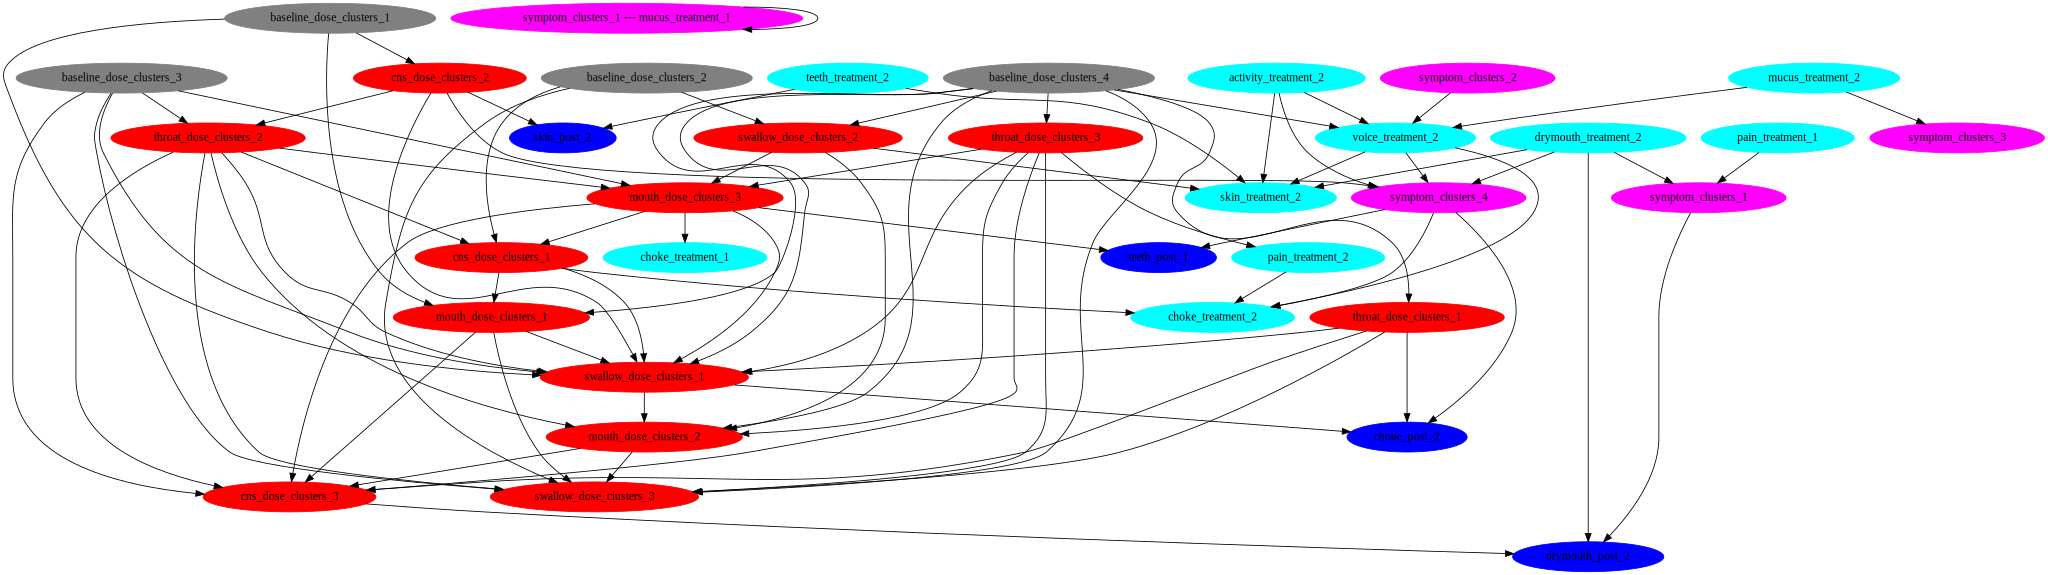

In [21]:

def dir_edge(edge):
    target = re.sub('[a-zA-Z_0-9]*\s*-->','',edge).strip()
    source = re.sub('-->\s*[a-zA-Z_0-9]*','',edge).strip()
    target = target.replace('symptoms_','').replace('max_','')
    source = source.replace('symptoms_','').replace('max_','')
    return source,target

def get_edge_dict(graph,treatments=None,outcomes=None,fixed=None):
    edgedict = {}
    for edge in graph.getEdges():
        source,target = dir_edge(edge)
        curredge = edgedict.get(target,[])
        curredge.append(source)
        edgedict[target] = curredge
    return edgedict

def print_graph(tetrad=None,
                edgedict=None,
               ):
    assert(tetrad is not None or edgedict is not None)
    if edgedict is None:
        edgedict = get_edge_dict(tetrad)
    gviz = Digraph('G')
    edgedict = {k:v for k,v in edgedict.items() if ('clusters_' in k) or np.any(['dose' in vv for vv in v])}
    all_nodes = set(edgedict.keys())
    for k,v in edgedict.items():
        for item in v:
            all_nodes.add(item)
    for node in all_nodes:
        color='red'
        if 'dose' not in node:
            if 'cluster' in node:
                color = 'magenta'
            elif 'treatment' in node:
                color = 'cyan'
            else:
                color = 'blue'
        elif 'baseline' in node:
            color = 'grey'
#         node = node.replace('symptoms_','').replace('max_','')
        gviz.node(node,style='filled',color=color)
    for node,parents in edgedict.items():
        for parent in parents:
            gviz.edge(parent,node)
    return gviz

print_graph(tetrad)

In [9]:
# pc.stop_vm()